<a href="https://colab.research.google.com/github/calerovillalobos10/Analisis_DatsetOriginal/blob/main/Proyecto_PF_3347.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Análisis de Datos con Dataset Original

## Estudiantes

*   Bryan Thomas Calero Villalobos
*   Daniela Montero Parkinson
*   Christopher Zúñiga Cárdenas

# Explicación del DataSet

# Problemática a Resolver

# Historia o Narrativa

# Uso práctico

## Extracción de datos

Como primer paso se instalan las librerías necesarias para poder hacer todos los procesos que se realizarán en este análisis de datos

In [1]:
!pip3 install requests
!pip3 install pandas
!pip3 install urllib
!pip3 install io
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scipy
!pip3 install sklearn

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib
ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Se importan las librerías para poder utilizarlas en los métodos definidos

In [2]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas import json_normalize
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from urllib.parse import urlencode
from io import StringIO
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
api_url = f'https://sdmx.oecd.org/public/rest/data/OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB_EDU,1.0/all?dimensionAtObservation=AllDimensions&format=csvfilewithlabels'

Este método se implementó para realizar reintentos en caso de que no responda el request que se está realizando.

Su funcionalidad se basa en crear una sesión HTTP que aplica reintentos automáticos cuando se producen errores temporales o de conexión en solicitudes GET.

In [4]:
# Método para crear la estrategia de reintentos
def create_retry_session(max_retries):
    retry_strategy = Retry(
        total=max_retries,  # Número máximo de reintentos
        status_forcelist=[408, 500, 502, 503, 504],  # Errores a los que se aplicarán los reintentos
        allowed_methods=["GET"],  # Solo reintentar en solicitudes GET
        backoff_factor=1  # Tiempo de espera entre reintentos
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)

    # Crear una sesión de requests con el adaptador de reintentos
    http = requests.Session()
    http.mount("https://", adapter)

    return http  # Devolver la sesión con la estrategia de reintentos

Se procede a realizar un consumo para obtener los datos desde el origen

In [5]:
def fetch_data(api_url, http, max_retries=1):

  try:
    headers = {"accept": "application/json"} # Encabezados de la solicitud, incluyendo la API Key

    response = http.get(api_url, headers=headers) # Realiza la solicitud HTTP al API
    response.raise_for_status() # Lanza un error si la respuesta no es exitosa

    csv_data = StringIO(response.text)
  except requests.RequestException as e:
    print(f"{country} No más datos")

  return csv_data

Se invoca al método que crea la sesión con reintentas pasándole la cantidad de reintentos que se desean tener

In [6]:
max_retries = 2
http = create_retry_session(max_retries) #método para crear la sesión con reintentos

Se llama a la función para recuperar todos los datos del dataset

In [7]:
# Llamar a la función
all_data = fetch_data(api_url, http, max_retries)

## Análisis EDA Exploratorio

### Exploración Inicial del Dataset

#### Proyección de primeros registros del Dataset

Se crea un DataFrame con los datos recuperados del método fetch, con el fin de imprimir las primeras instancias e identificar cómo está formado y cuáles serán los posibles datos que tendrá cada columna

In [8]:
df_original = pd.read_csv(all_data)
df_original.head(10)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,MEASURE,Measure,UNIT_MEASURE,Unit of measure,...,OBS_VALUE,Observation value,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals,BASE_PER,Base period
0,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
1,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
2,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
3,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
4,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
5,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
6,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
7,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
8,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN
9,DATAFLOW,OECD.WISE.WDP:DSD_HSL@DF_HSL_CWB_EDU(1.0),Current well-being by education level,I,DNK,Denmark,11_2,Negative affect balance,PT_POP_Y_GE15_SUB,Percentage of population aged 15 years or over...,...,8.35622,NaN,A,Normal value,0,Units,2,Two,NaN,NaN


#### Estructura y resumen de los datos

Se utiliza el método ".info" para obtener un resumen rápido de la estructura del DataFrame

In [9]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12286 entries, 0 to 12285
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STRUCTURE           12286 non-null  object 
 1   STRUCTURE_ID        12286 non-null  object 
 2   STRUCTURE_NAME      12286 non-null  object 
 3   ACTION              12286 non-null  object 
 4   REF_AREA            12286 non-null  object 
 5   Reference area      12286 non-null  object 
 6   MEASURE             12286 non-null  object 
 7   Measure             12286 non-null  object 
 8   UNIT_MEASURE        12286 non-null  object 
 9   Unit of measure     12286 non-null  object 
 10  AGE                 12286 non-null  object 
 11  Age                 12286 non-null  object 
 12  SEX                 12286 non-null  object 
 13  Sex                 12286 non-null  object 
 14  EDUCATION_LEV       12286 non-null  object 
 15  Education level     12286 non-null  object 
 16  DOMA

El método de pandas ".describe" retorna los datos de: promedio, conteo, min, max , persentiles 25/50/75 y desviacion estandar por cada columna de tipo numérico.

In [10]:
df_original.describe()

,TIME_PERIOD,Time period,OBS_VALUE,Observation value,UNIT_MULT,DECIMALS,BASE_PER,Base period
count,12286.000000,0.0,12286.000000,0.0,12286.0,12286.0,0.0,0.0
mean,2014.609474,NaN,72.581038,NaN,0.0,2.0,NaN,NaN
std,4.868647,NaN,100.860416,NaN,0.0,0.0,NaN,NaN
min,2004.000000,NaN,0.024030,NaN,0.0,2.0,NaN,NaN
25%,2011.000000,NaN,11.072614,NaN,0.0,2.0,NaN,NaN
50%,2015.000000,NaN,62.000000,NaN,0.0,2.0,NaN,NaN
75%,2018.000000,NaN,84.241020,NaN,0.0,2.0,NaN,NaN
max,2023.000000,NaN,558.212230,NaN,0.0,2.0,NaN,NaN


#### Exploración de valores nulos

Se utiliza el método ".isnull().sum()" para determinar las columnas que poseen datos vacíos en el conjunto de datos y la cantidad que poseen.

In [11]:
print(f'Cantidad de nulos: \n')
nulos = df_original.isnull().sum()

Cantidad de nulos: 



#### Detección de datos duplicados

Para evitar conclusiones incorrectas, es necesario eliminar los duplicados del dataset.

Se utiliza el método ".duplicated().sum()" para determinar la cantidad de valores duplicados

In [12]:
print(f'Cantidad de duplicados: \n')
duplicados = df_original.duplicated().sum()

Cantidad de duplicados: 



#### Identificar relevancia de las variables

 Se procede a identificar y descartar columnas que no aportan información relevante para el análisis. Las columnas con 1 o menos subniveles no son útiles, debido a que no varían y, por lo tanto, no pueden contribuir a la diferenciación o clasificación en el análisis de datos.

In [13]:
cols_cat = df_original.columns.tolist() # se capturan los nombres de las columnas del DF

col_descartadas = [] # se inicializa un array para capturar las columnas que se descartarán por poca relevancia

# Se identifican cuántos subniveles tiene cada columna
for col in cols_cat:
  print(f'Columna {col}: {df_original[col].nunique()} subniveles o distintos.')

  if(df_original[col].nunique() <= 1):
    col_descartadas.append(col)

Columna STRUCTURE: 1 subniveles o distintos.
Columna STRUCTURE_ID: 1 subniveles o distintos.
Columna STRUCTURE_NAME: 1 subniveles o distintos.
Columna ACTION: 1 subniveles o distintos.
Columna REF_AREA: 40 subniveles o distintos.
Columna Reference area: 40 subniveles o distintos.
Columna MEASURE: 17 subniveles o distintos.
Columna Measure: 17 subniveles o distintos.
Columna UNIT_MEASURE: 10 subniveles o distintos.
Columna Unit of measure: 10 subniveles o distintos.
Columna AGE: 1 subniveles o distintos.
Columna Age: 1 subniveles o distintos.
Columna SEX: 1 subniveles o distintos.
Columna Sex: 1 subniveles o distintos.
Columna EDUCATION_LEV: 3 subniveles o distintos.
Columna Education level: 3 subniveles o distintos.
Columna DOMAIN: 8 subniveles o distintos.
Columna Domain: 8 subniveles o distintos.
Columna TIME_PERIOD: 20 subniveles o distintos.
Columna Time period: 0 subniveles o distintos.
Columna OBS_VALUE: 6803 subniveles o distintos.
Columna Observation value: 0 subniveles o disti

#### Identificación de Outliers

Eliminar espacios al principio y al final en todas las columnas de texto para mantener un estandar y buenas prácticas de limpieza

In [14]:
def trim_column_names(df):
  df.columns = df.columns.str.strip()
  return df

Se invoca a la función para eliminar los espacios al principio y al final de los nombres de las columnas

In [15]:
df_original = trim_column_names(df_original)

Se aplica un histograma para revisar outliers. El método genera un histograma para cada columna numérica en el DataFrame

In [16]:
def plot_histograms(df):
  # Filtrar solo las columnas numéricas
  numeric_columns = df.select_dtypes(include=['number']).columns

  # Crear un histograma para cada columna numérica
  for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(f'Histograma del parámetro: {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

    # Mostrar el gráfico
    plt.show()

Se procede a generar un gráfico de caja (boxplot) para cada columna numérica especificada en el DataFrame. Para revisar outliers en variables numericas

In [18]:
def plot_boxplots(df, cols_num):
  # Definir la estructura del gráfico
  fig, ax = plt.subplots(nrows=len(cols_num), ncols=1, figsize=(8, 10))
  fig.subplots_adjust(hspace=0.5)  # Espacio entre gráficos

  # Crear un boxplot para cada columna válida
  for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i])  # Crear el gráfico de caja
    ax[i].set_title(f'Gráfico del parámetro: {col}')  # Establecer el título del gráfico

# Mostrar los gráficos
plt.show()

Este método funciona para imprimir el valor mínimo y máximo de cada columna numérica en el DataFrame

In [19]:
def print_min_max_values(df, cols_num):
  # Filtrar solo las columnas numéricas
  cols_num = df.select_dtypes(include=['number']).columns

  # Iterar sobre cada columna numérica y calcular min y max
  for col in cols_num:
    min_value = df[col].min()
    max_value = df[col].max()
    print(f'Columna: {col}')
    print(f'Datos menor: {min_value}')
    print(f'Datos mayor: {max_value}\n')

Método para graficar los subniveles de cada variable categórica para identificar outliers. Se utiliza para identificar outliers en las columnas de tipo categoría. Esto con el fin de detectar, por ejemplo: mayúsculas, minúscualas, tildes dentro de las mismas categorías. Además, se grafican los parámetros de categorías con el fin de identicar si hay algún dato que necesita ser unificado, por nombre con mayúsculas o minúsculas

In [20]:
def plot_categories(df, cols_cat):
  # Crear figura y ejes
  fig, ax = plt.subplots(nrows=len(cols_cat), ncols=1, figsize=(10, 10 * len(cols_cat)))
  fig.subplots_adjust(hspace=0.25)  # Ajustar espacio entre subplots

  # Iterar por cada columna categórica
  for i, col in enumerate(cols_cat):
    sns.countplot(y=col, data=df, ax=ax[i], hue=col, palette='Set2')
    ax[i].set_title(f'Gráfico del parámetro: {col}')

    ax[i].tick_params(axis='y', rotation=0) # Usar plt.xticks() para rotar etiquetas sin problemas de locators

# Mostrar el gráfico
plt.show()

Se crean variables con las columnas numéricas del dataframe, y las categóricas

In [21]:
cols_num = df_original.select_dtypes(include=['number']).columns
cols_cat = []

Validar que las columnas sean realmente numéricas

In [22]:
def validate_numeric_columns(df, cols_num):
  valid_cols = []
  for col in cols_num:
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]) and df[col].notnull().any():
      valid_cols.append(col)
    else:
      print(f"Columna '{col}' no válida. Se omitirá.")

  if not valid_cols:
    print("No hay columnas numéricas válidas para graficar.")

  return valid_cols

Llamada de funciones

Columna 'Time period' no válida. Se omitirá.
Columna 'Observation value' no válida. Se omitirá.
Columna 'BASE_PER' no válida. Se omitirá.
Columna 'Base period' no válida. Se omitirá.


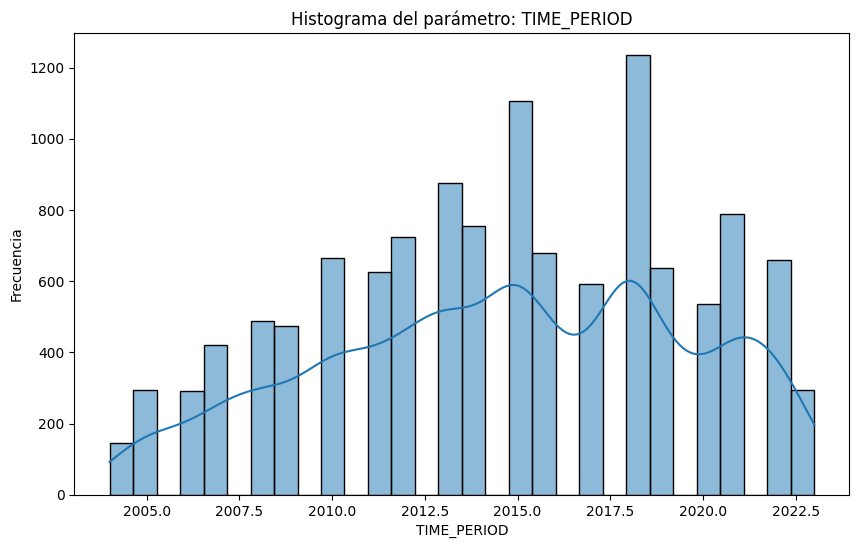

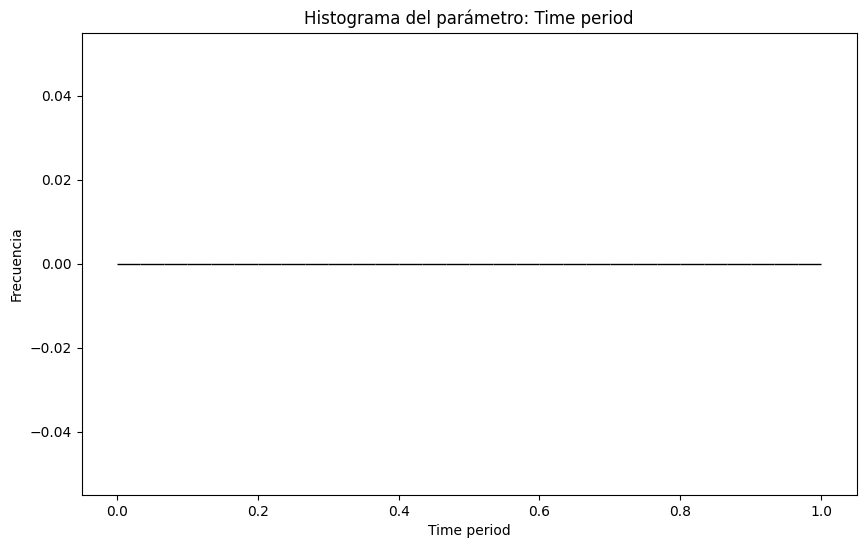

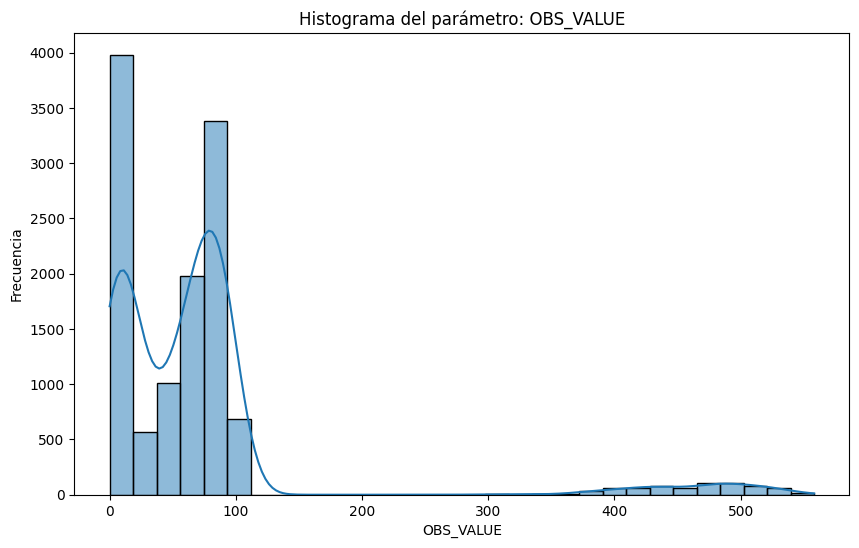

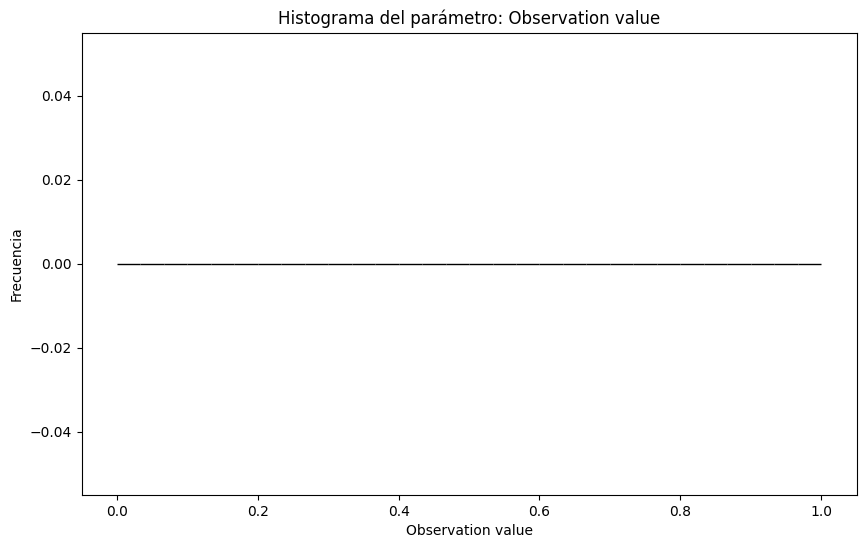

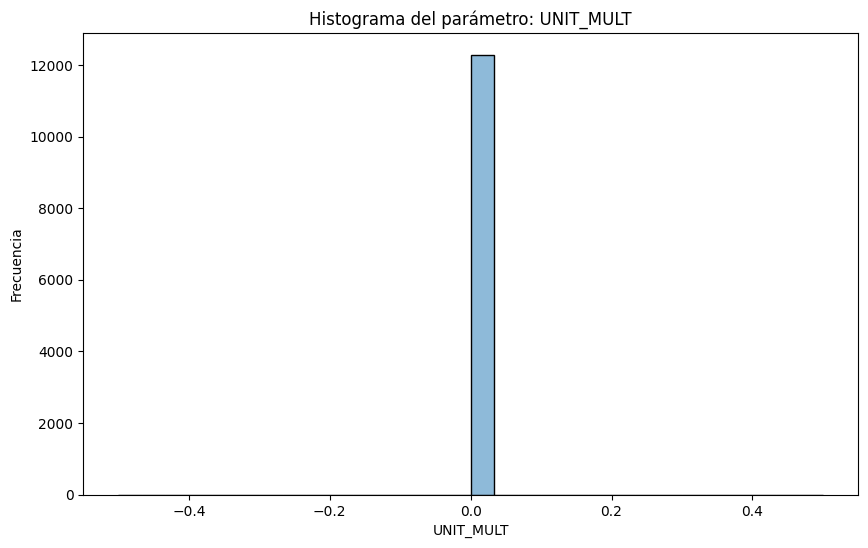

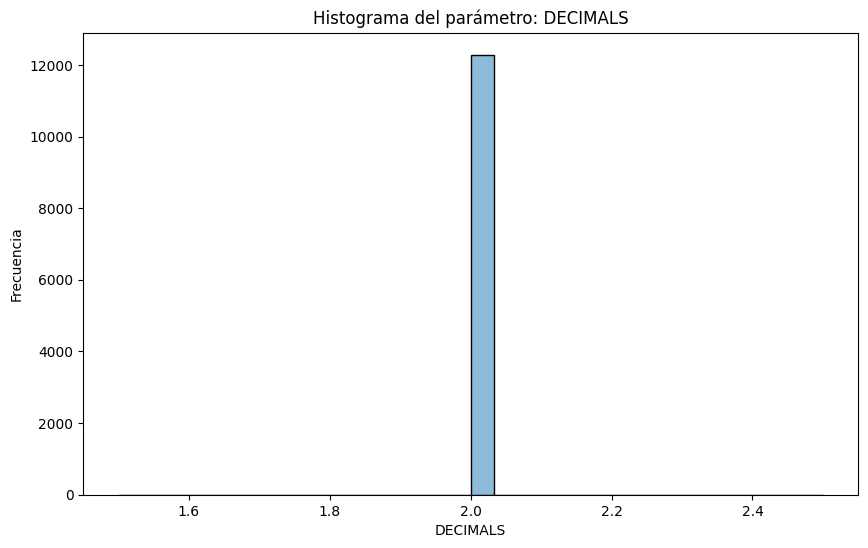

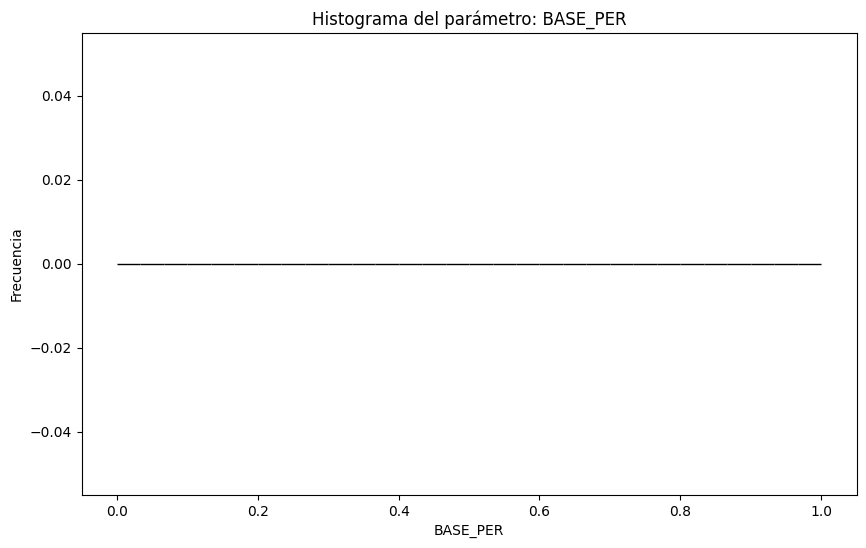

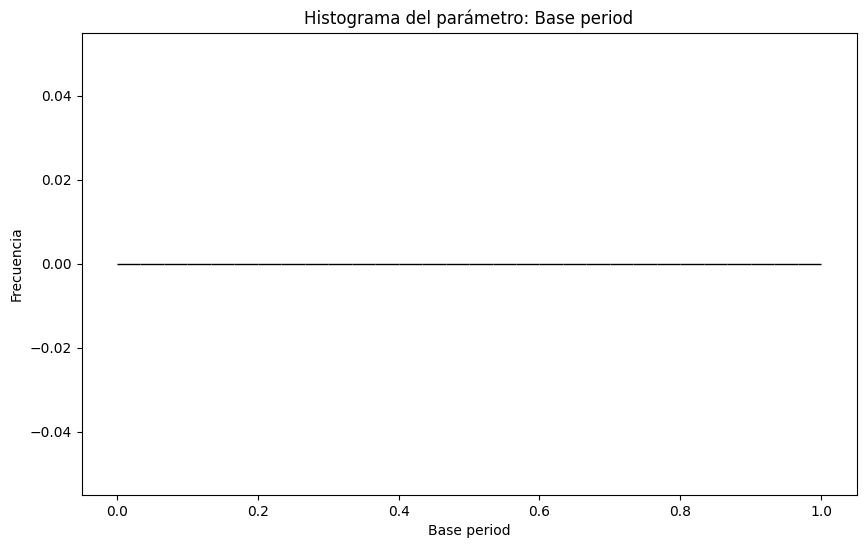

Columna: TIME_PERIOD
Datos menor: 2004
Datos mayor: 2023

Columna: Time period
Datos menor: nan
Datos mayor: nan

Columna: OBS_VALUE
Datos menor: 0.0240298415411054
Datos mayor: 558.21223

Columna: Observation value
Datos menor: nan
Datos mayor: nan

Columna: UNIT_MULT
Datos menor: 0
Datos mayor: 0

Columna: DECIMALS
Datos menor: 2
Datos mayor: 2

Columna: BASE_PER
Datos menor: nan
Datos mayor: nan

Columna: Base period
Datos menor: nan
Datos mayor: nan



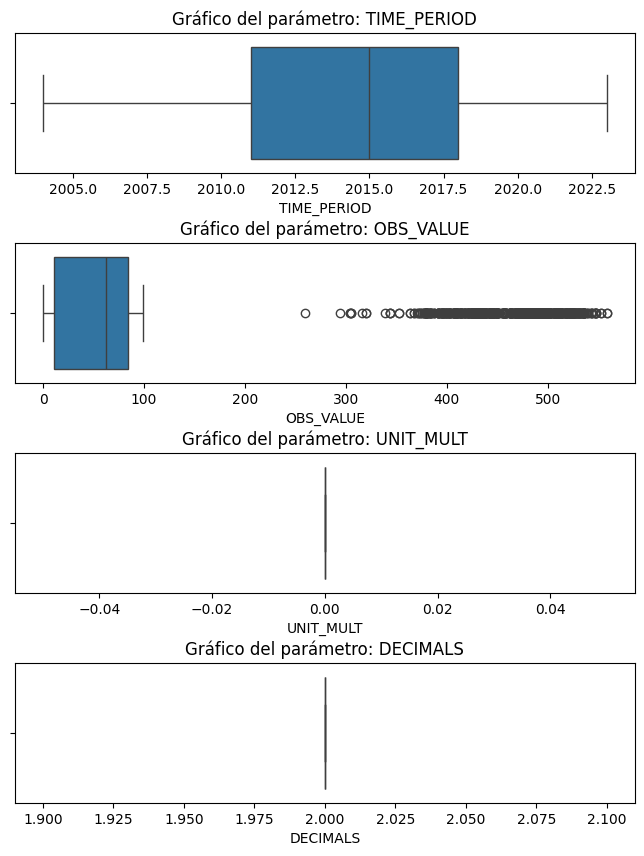

In [23]:
valid_columns = validate_numeric_columns(df_original, cols_num)

plot_histograms(df_original) # Llamada a la función que crea los histogramas
plot_boxplots(df_original, valid_columns) # Llamada a la función que crea los gráficos de caja
#plot_categories(df_original, cols_cat) # Llamada a la función que crea los gráficos de barras para detectar visualmente si hay categorías diferentes
print_min_max_values(df_original, valid_columns) # Llama a la función que imprime el mínimo y el máximo de cada columna numérica

#### Análisis Multivariable

Se realiza un análisis Multiversal para comprender la relación entre las variables. Primero se extraen las columnas númericas para posteriormente generar la matriz de correlacion que muestre la relación entre las columnas obtenidas, para esto se utiliza el método ".corr()".

In [24]:
df_numerico = df_original.select_dtypes(include=['number','int64', 'float64']) # Obtención de las columnas númericas

correlacion = df_numerico.corr() # Calcular la matriz de correlación
correlacion

,TIME_PERIOD,Time period,OBS_VALUE,Observation value,UNIT_MULT,DECIMALS,BASE_PER,Base period
TIME_PERIOD,1.000000,NaN,0.063431,NaN,NaN,NaN,NaN,NaN
Time period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OBS_VALUE,0.063431,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Observation value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNIT_MULT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DECIMALS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BASE_PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Base period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Una vez se posea la matriz de correlación, procedemos a generar un mapa de calor para analizar los datos de una manera visual con el comando ".heatmap()" de la librería seaborn.
Para el análisis del mapa se toma lo siguiente:
* Colores cálidos(rojos): correlaciones positivas. Indica que las columnas relacionadas van a aumentar o disminuir si la relación padre lo hace. Tambien, se puede intuir que si tienen una relación fuerte, se puede predecir o estimar el valor de la otra relacion.
* Colores fríos(azules): correlaciones negativas. Indica que las columnas relacionadas van a hacer lo contrario en caso de que disminuya o aumente la columna padre. Tambien, si es una relación debil, conocer una de las relaciones no ayuda a predecir el valor de la otra.
* Colores de la gama del blanco: poca o ninguna correlación.

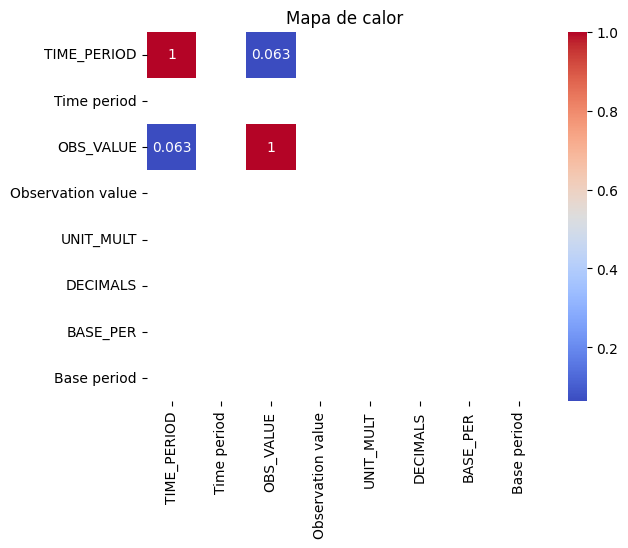

In [25]:
# Mapa de calor de la matriz de correlación
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title('Mapa de calor')
plt.show()

#### Análisis Univariable

Se realiza un análisis univariable para resumir las tendencias y presencias en los valores atípicos.

<Figure size 1500x1500 with 0 Axes>

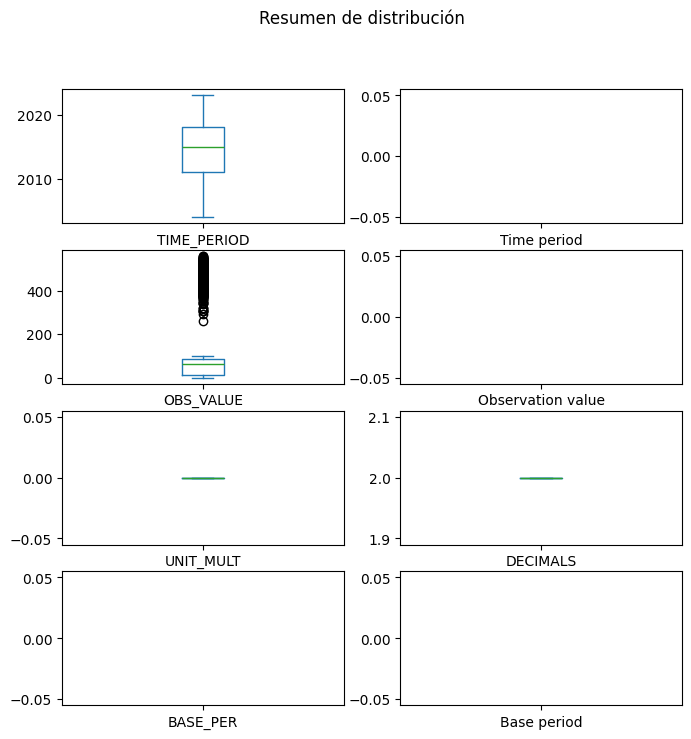

In [26]:
plt.figure(figsize=(15, 15))
df_numerico.plot(kind='box', subplots=True, layout=(int(len(df_numerico.columns)/2), 2), figsize=(8, 8), title='Resumen de distribución')
plt.show()

### Descripción del conjunto de datos

El conjunto de datos consta de...

### Análisis de los parámetros

#### Preguntas clave:

### Detección de valores atípicos en las mediciones

## Procesamiento de Datos (Limpieza de datos y Transformación)

### Eliminación de duplicados

El siguiente método se utiliza para detectar cuántos duplicados hay en los datos y eliminarlos si se encuentran

In [ ]:
def drop_duplicates(df, duplicados):
  if duplicados > 1:
    print(f'Tamaño previo: {df.shape}')

    df.drop_duplicates(inplace=True)

    print(f'Tamaño posterior: {df.shape}')
  else:
    print('No hay filas duplicadas')

# Llamada a la función para realizar el proceso
drop_duplicates(df_original, duplicados)

### Transformación de datos

Elimina los espacios en blanco al principio y al final de cada valor en un DataFrame siempre y cuando sea de tipo string o de tipo object

In [ ]:
def trim_whitespace(df):
  df = df.apply(lambda x: x.str.strip() if x.dtype == "object" || x.dtype == "str" else x)
  return df

Eliminar los espacios en blanco

In [ ]:
df_original = trim_whitespace(df_original)

Se procede a reemplazar los registros que posean '?' ya que es recomendable eliminar estas instancias. Debido a que no aportan nada al entrenamiento de los modelos y también porque así se realiza una estandarización en los datos

In [ ]:
df_original.replace('?', np.nan, inplace=True)

Codificar las variables categóricas significa transformar las categorías en valores numéricos para que los algoritmos de Machine Learning puedan procesarlas. Esto se hará para ampliar la compatibilidad entre los algoritmos a utilizar.

El siguiente método aplica LabelEncoder a las columnas especificadas de un DataFrame

In [ ]:
def encode_labels(df, columns):
  label_encoder = LabelEncoder()  # Creamos el codificador

  for column in columns:
    if column in df.columns:
      df[column] = label_encoder.fit_transform(df[column])
    else:
      print(f'La columna "{column}" no se encuentra en el DataFrame.')

  return df

# Columnas a las que se le aplciará el label_encoder
columns_to_encode = ['', '', '']
df_data = encode_labels(df_data, columns_to_encode)

### Eliminación de nulos

Se proceden a eliminar nulos, ya que según el análisis realizado, la eliminación de estos nulos no afecta a la hora del entrenamiento de modelos o el análisis de los datos que se quiere realizar

In [ ]:
df_original.dropna()

### Eliminación de outliers

### Selección de características

Se proceden a eliminar las columnas menos relevantes (si es que las hay). Además, con "inplace=True": modifica datos directamente sin crear un dataframe nuevo

In [ ]:
df_original.drop(columns=col_descartadas, inplace=True)

## Análisis EDA luego de limpieza

### Entender la estructura de los datos

### Detección de valores atípicos (outliers)

### Detección de valores faltantes

## Implementación de los Algoritmos

### Distribución de datos para entrenamiento

Primero se debe separar las características (X) y la variable objetivo (y).

x = variables para realizar la predicción, se conocen tambien como variables de entrada o características.

y = variable predicción, se conoce como variable de salida o etiqueta

In [ ]:
X = df_data[['', '', '']]
y = df_data['']

Se procede a dividir el dataset en conjuntos de entrenamiento y prueba. El random_state se utiliza para establecer una semilla para el generador de números aleatorios. Esto garantiza que la división del conjunto de datos en conjuntos de entrenamiento y prueba sea reproducible. Utilizar el mismo random_state en diferentes ejecuciones permite evaluar cómo cambios en otros aspectos del modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Matrices de Confusión

### Modelo

### Modelo

### Modelo

### Modelo

## Análisis Comparativo de los Modelos

### Implementación de Keras

### Evaluación de desempeño

Creamos una función para evaluar el modelo con los datos de exactitud, precisión, exhaustividad y puntuación F1(Medida de balance entre precisión y exhaustividad)

In [ ]:
def evaluar_modelo(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
  recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
  f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

  return accuracy, precision, recall, f1

Se agrega en un listado los resultados de la evaluación de cada modelo para ser comparados en una tabla

In [ ]:
resultados = {} # Evaluación de cada modelo
resultados['Random Forest'] = evaluar_modelo(y_test, predict_random_forest) # Random Forest
resultados['Árbol de Decisión'] = evaluar_modelo(y_test, predict_decision_tree) # Árbol de Decisión
resultados['Naive Bayes'] = evaluar_modelo(y_test, predict_naive_bayes) # Naive Bayes
resultados['Redes Neuronales'] = evaluar_modelo(y_test, predict_neural_network) # Redes Neuronales

### Matrices de Confusión

## Comparativa y Visualización de datos

### Distribución

### Análisis de tendencia

## Síntesis de Resultados

### Hallazgos Clave

### Resultados vs Hipótesis

### Acciones

# Conclusiones

# Referencias

Cramér, H. (1946). Mathematical Methods of Statistics. Princeton University Press.

Guzman, M. (2022, 23 de mayo). *Guía para limpiar datos con Pandas*. Medium. https://medium.com/nowports-tech/guia-limpiar-datos-con-pandas-3dc634c47e11

Nik. (s.f.). How to Calculate Cramer’s V in Python. datagy.io1. Recuperado de  https://datagy.io/cramers-v-python/

The pandas development team. (2024). *pandas.DataFrame — pandas 2.1.1 documentation.* https://pandas.pydata.org/docs/reference/frame.html